# **Otimização - Toy Experiment: Mitigação de Crosstalk**
## **Notebook de Geração de Dados**

**Disciplina:** PPGEE0016 - Otimização

**Alunos:** André Paiva, Josias Souza, Victor Emanuel Paz

In [1]:
import os
import sys
sys.path.insert(1, "../crosstalk/")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns

from functions import *
from XTconstants import *

sns.set_context("paper", font_scale=2.0)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Setting a random seed for reproducibility. Using a fixed seed value (5) ensures that the random numbers generated
# are the same across different runs of the code. This is important for verifying results, as it allows
# for consistent experimentation and comparison of outcomes.
np.random.seed(5)

In [3]:
cellFunctionVec = np.vectorize(cellFunction)
XTalkVec = np.vectorize(XTalk)

In [4]:
def signals_gen(signals_amount=100, n_samples=4, sampling_period=25):
    """
    Function to generate samples from signal contaminated by crosstalk.

    Parameters
    ----------
    ``signals_amount``: Amount of signals to be generated (default is 100).
    ``n_samples``: Amount of samples per signal to be generated (default is 4).
    ``sampling_period``: Time distance between samples (default is 25ns).

    Returns
    -------
    Dataframe containing signal shaping parameters and samples of approximated function according to given parameters.

    """
    
    E = np.abs(np.random.normal(loc=55000, scale=10000, size=signals_amount))
    E_x = np.abs(np.random.normal(loc=4000, scale=1000, size=signals_amount))
    clean_timescale = np.random.uniform(0.7, 1.4, size=signals_amount)
    xt_timescale = np.random.uniform(0.8, 2.5, size=signals_amount)
    random_sampling_delay = np.abs(np.random.normal(loc=2, scale=3, size=signals_amount))
    data = np.stack([E, E_x, clean_timescale, xt_timescale, random_sampling_delay], axis=1)
    columns = ["E", "E_x", "timescale_clean", "timescale_xt", "delay_sampling"]
    signals_df = pd.DataFrame(data, columns=columns)

    

    continuous_precision = 0.01
    time_axis = np.repeat(np.arange(0, 600, continuous_precision).reshape(-1, 1), signals_amount, axis=1)
    clean_timescale_vec = time_axis * clean_timescale
    xt_timescale_vec = time_axis * xt_timescale
    continuous_etrue = E*cellFunctionVec(clean_timescale_vec)
    continuous_xt = E_x*XTalkVec(xt_timescale_vec)
    #continuous_xt = np.array([E_x[j]*XTalkVec(np.array([i*xt_timescale[j] for i in np.arange(0, 600, continuous_precision)])) for j in range(signals_amount)])
    continuous_signal = np.transpose(continuous_etrue + continuous_xt)

    tau = np.argmax(continuous_etrue, axis=0)*continuous_precision
    tau_x = np.argmax(continuous_xt, axis=0)*continuous_precision
    signals_df["tau"] = tau
    signals_df["tau_x"] = tau_x
    signals_df["sampling_period"] = np.repeat([sampling_period], signals_amount)

    #plt.plot(continuous_etrue.T)
    #plt.plot(continuous_xt.T)
    plt.plot(np.arange(0, 600, continuous_precision), continuous_signal.T)
    plt.xlabel("Tempo (ns)")
    plt.ylabel("Energia (MeV)")
    plt.tight_layout()
    plt.savefig("signals_gen.pdf")

    samples_columns = [f"S_{i}" for i in range(1, n_samples+1)]
    for i in range(n_samples):
        clean_samples = np.array([E[j]*cellFunction(sampling_period*(i+1)*clean_timescale[j] + signals_df["delay_sampling"][j]) for j in range(signals_amount)])
        xt_samples = np.array([E_x[j]*XTalk(sampling_period*(i+1)*xt_timescale[j] + signals_df["delay_sampling"][j]) for j in range(signals_amount)])
        samples = clean_samples + xt_samples
        signals_df[samples_columns[i]] = samples
    
    return signals_df
    

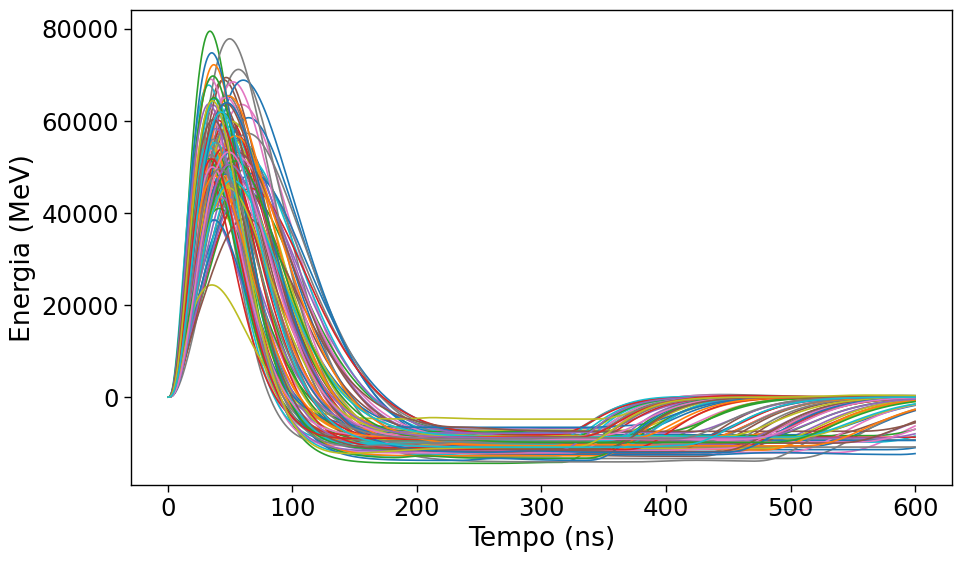

In [5]:
data = signals_gen()

In [6]:
data

,E,E_x,timescale_clean,timescale_xt,delay_sampling,tau,tau_x,sampling_period,S_1,S_2,S_3,S_4
0,59412.274869,4792.422617,0.833459,1.861120,3.271603,56.08,17.28,25,36628.139188,56017.230291,46173.096004,25153.393190
1,51691.298481,4170.764452,1.143950,1.382774,0.838006,40.86,23.26,25,42583.959191,46295.148692,19792.438474,1969.545282
2,79307.711870,2246.259140,1.356987,1.596575,0.570604,34.45,20.14,25,70982.377518,58703.986365,14629.961111,-6061.920666
3,52479.078704,4630.296477,0.880730,0.904404,4.445942,53.07,35.56,25,38643.639887,54477.231823,36248.645619,14829.577108
4,56096.098416,4498.329215,0.904736,1.683603,1.502552,51.67,19.10,25,35661.076827,53261.092284,39592.473056,18641.196463
5,70824.811171,5018.137610,0.997951,1.563562,9.936060,46.84,20.57,25,65080.939470,60308.282475,30568.821270,7406.060652
6,45907.675951,3153.531383,1.099825,1.308271,1.251590,42.50,24.58,25,36393.960047,42532.755996,20105.789341,3432.312901
7,49083.633421,6520.807634,1.393039,1.093891,0.152014,33.56,29.40,25,49418.046108,37939.546587,5163.228465,-7620.700532
8,56876.032258,2767.613885,1.111740,1.379128,0.351508,42.05,23.32,25,42899.565257,52793.273566,25604.905899,4625.277914
9,51701.300422,4726.953261,1.321530,1.301246,3.113261,35.37,24.71,25,51237.094295,37428.393461,7576.081265,-5094.060715


In [7]:
if not os.path.exists("./dataset/"):
    os.mkdir("dataset/")

data.to_csv("./dataset/data.csv")